# Training feature selection

## Description

...


## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd

import json
from collections import Counter
from pprint import pprint

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import matplotlib.cm as cm

import numpy as np
import pandas as pd
from joblib import dump

import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

import warnings  # Import the warnings module

import matplotlib.colors as mcolors

from statsmodels.stats.outliers_influence import variance_inflation_factor

## Load training data and label dictionary

We will load the training data saved from the [feature extracion notebook](3_Training_feature_extraction.ipynb), along with the mapping between crop labels and the numerical classes.

In [2]:
dataset_name1 = 'sb16_17';
dataset_name2 = 'sb17_18';
dataset_name3 = 'sb18_19';
dataset_name4 = 'sb19_20';
dataset_name5 = 'sb20_21';

dataset_suffix = '_tree_cleaned';

# User-defined threshold
min_valid_weeks = 10

predictor_column = 6; # Column where we start selecting the predictors
ndvi_threshold = .2; # NDVI min Threshold

In [3]:
base_path = 'Input'
output_file1 = os.path.join(base_path, f'{dataset_name1}{dataset_suffix}.csv')
output_file2 = os.path.join(base_path, f'{dataset_name2}{dataset_suffix}.csv')
output_file3 = os.path.join(base_path, f'{dataset_name3}{dataset_suffix}.csv')
output_file4 = os.path.join(base_path, f'{dataset_name4}{dataset_suffix}.csv')
output_file5 = os.path.join(base_path, f'{dataset_name5}{dataset_suffix}.csv')
# Load the newly generated CSV file
df1 = pd.read_csv(output_file1)
df2 = pd.read_csv(output_file2)
df3 = pd.read_csv(output_file3)
df4 = pd.read_csv(output_file4)
df5 = pd.read_csv(output_file5)
# add df1 to df
# df = pd.concat([df1,df2,df3,df4,df5], ignore_index=True)
df = pd.concat([df1,df2,df3], ignore_index=True)
# print the number of rows
print(f"Number of rows: {len(df)}")
df = df.dropna()
print(df.shape)

Number of rows: 8838618
(8838618, 54)


In [4]:
# remove from df the crop types WheatMaize,WheatSunflower,WheatSoya and put them in a new df
df_wheat = df[df['Crop_type'].isin(['WheatMaize','WheatSunflower','WheatSoya'])]
df = df[~df['Crop_type'].isin(['WheatMaize','WheatSunflower','WheatSoya'])]

print(df.shape)
print(df_wheat.shape)

(8715337, 54)
(123281, 54)


In [5]:
# Separate wheat-only weeks (week 17 to 47)
df_wheat_only = df_wheat[(df_wheat['week'] >= 17) & (df_wheat['week'] <= 44)].copy()
df_wheat_only['Crop_type'] = 'Wheat'

# Separate non-wheat weeks (before 17 or after 47)
df_non_wheat = df_wheat[(df_wheat['week'] < 17) | (df_wheat['week'] > 44)].copy()

# Map back to original crop types without "Wheat" prefix
crop_map = {
    'WheatMaize': 'Maize',
    'WheatSunflower': 'Sunflower',
    'WheatSoya': 'SoyaBeans'
}
df_non_wheat['Crop_type'] = df_non_wheat['Crop_type'].map(crop_map)

# Concatenate cleaned parts back into main DataFrame
df = pd.concat([df, df_wheat_only, df_non_wheat], ignore_index=True)

# Check shapes
print("Final df shape:", df.shape)


Final df shape: (8838618, 54)


In [6]:
# Remove rows with veg_median_ndvi < threshold
df1 = df[df['veg_median_ndvi'] >= ndvi_threshold]
# Print the number of included rows
print(f'The number of included rows is: {df1.shape[0]}')
# Print the number of removed rows
print(f'The number of removed rows is: {df.shape[0] - df1.shape[0]}')
below_threshold = df[df['veg_median_ndvi'] < ndvi_threshold].shape[0]
above_threshold = df[df['veg_median_ndvi'] >= ndvi_threshold].shape[0]

# Check shapes
print("Final df shape:", df1.shape)


The number of included rows is: 3821035
The number of removed rows is: 5017583
Final df shape: (3821035, 54)


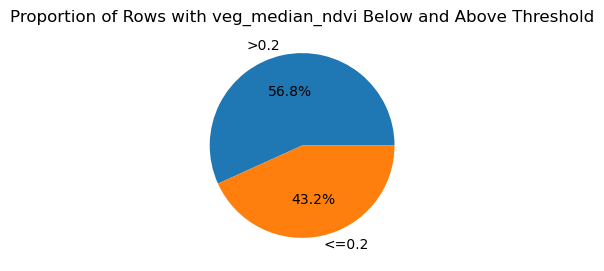

In [7]:
# Create a pie chart
plt.figure(figsize=(3, 3))
plt.pie([below_threshold, above_threshold], labels=['>' + str(ndvi_threshold), '<=' + str(ndvi_threshold)], autopct='%1.1f%%')
plt.title('Proportion of Rows with veg_median_ndvi Below and Above Threshold')
plt.show()

In [8]:
# If df1 is a slice, ensure you're working on a copy
df1 = df1.copy()

# Add the new column using .loc to avoid the warning
df1.loc[:, 'Irrigation_code'] = df1['Irrigation'].apply(lambda x: 1 if x == 'Irrigated' else 0)

# Print counts
print(f"Number of rows with Irrigation_code = 1: {len(df1[df1['Irrigation_code'] == 1])}")
print(f"Number of rows with Irrigation_code = 0: {len(df1[df1['Irrigation_code'] == 0])}")


Number of rows with Irrigation_code = 1: 388847
Number of rows with Irrigation_code = 0: 3432188


In [9]:
# Drop unwanted columns
df1 = df1.drop(columns=['Irrigation', 'catname', 'no_of_crop'])

# Rename 'Irrigation_code' to 'Irrigation'
df1 = df1.rename(columns={'Irrigation_code': 'Irrigation'})



In [10]:
# Visualize the features in the dataset
features = df1.columns
# Print the number of predictors
print(f'The number of features is: {len(features)}')
# List the potential predictors
print(features)

The number of features is: 52
Index(['FIELDID', 'Crop_type', 'area_ha', 'Year', 'week', 'chirps_mean_prec',
       'chirps_sum_prec', 'chirps_max_prec', 'chirps_min_prec',
       'chirps_std_prec', 'chirps_cnt_prec', 'era5_temp2m', 'era5_temp2mmin',
       'era5_temp2max', 'era5_totprec', 'era5_rh', 'era5_swi',
       'era5_evaporation_from_bare_soil_sum', 'veg_mean_evi', 'veg_mean_lai',
       'veg_mean_pvr', 'veg_mean_msi', 'veg_mean_ndvi', 'veg_median_evi',
       'veg_median_lai', 'veg_median_pvr', 'veg_median_msi', 'veg_median_ndvi',
       'veg_max_evi', 'veg_max_lai', 'veg_max_pvr', 'veg_max_msi',
       'veg_max_ndvi', 'veg_min_evi', 'veg_min_lai', 'veg_min_pvr',
       'veg_min_msi', 'veg_min_ndvi', 'veg_std_evi', 'veg_std_lai',
       'veg_std_pvr', 'veg_std_msi', 'veg_std_ndvi', 'sar_vh', 'sar_vv',
       'sar_angle', 'sar_sigma_vh_linear', 'sar_sigma_vv_linear',
       'sar_p_ratio', 'sar_rvi', 'sar_rcspr', 'Irrigation'],
      dtype='object')


In [11]:
# in Crop_type, rename SoyaBeans to Soy
df1['Crop_type'] = df1['Crop_type'].replace('SoyaBeans', 'Soy')

In [12]:
# Define mapping from Crop_type to Crop_num
crop_map = {
    'Maize': 0,
    'Soy': 1,  
    'Sunflower': 2,
    'Wheat': 3,
    'Lucern': 4,
    'Pasture': 5,
    'Tree': 6,
    'Fallow': 7,
    'Groundnuts': 8,
    'Sorghum': 9
}

# Apply the mapping to create the new column
df1['Crop_num'] = df1['Crop_type'].map(crop_map)

# Check if there are any unmapped values (should be NaN in Crop_num)
unmapped = df1[df1['Crop_num'].isna()]['Crop_type'].unique()
if len(unmapped) > 0:
    print("Unmapped Crop_type values:", unmapped)


In [13]:
# Reorder columns to place 'Crop_num' right after 'Crop_type'
cols = df1.columns.tolist()
crop_type_idx = cols.index('Crop_type')
# Remove 'Crop_num' from its current position
cols.remove('Crop_num')
# Insert 'Crop_num' right after 'Crop_type'
cols.insert(crop_type_idx + 1, 'Crop_num')

# Reassign DataFrame with new column order
df1 = df1[cols]

In [14]:
# Visualize the features in the dataset
features = df1.columns
# Print the number of predictors
print(f'The number of features is: {len(features)}')
# List the potential predictors
print(features)

The number of features is: 53
Index(['FIELDID', 'Crop_type', 'Crop_num', 'area_ha', 'Year', 'week',
       'chirps_mean_prec', 'chirps_sum_prec', 'chirps_max_prec',
       'chirps_min_prec', 'chirps_std_prec', 'chirps_cnt_prec', 'era5_temp2m',
       'era5_temp2mmin', 'era5_temp2max', 'era5_totprec', 'era5_rh',
       'era5_swi', 'era5_evaporation_from_bare_soil_sum', 'veg_mean_evi',
       'veg_mean_lai', 'veg_mean_pvr', 'veg_mean_msi', 'veg_mean_ndvi',
       'veg_median_evi', 'veg_median_lai', 'veg_median_pvr', 'veg_median_msi',
       'veg_median_ndvi', 'veg_max_evi', 'veg_max_lai', 'veg_max_pvr',
       'veg_max_msi', 'veg_max_ndvi', 'veg_min_evi', 'veg_min_lai',
       'veg_min_pvr', 'veg_min_msi', 'veg_min_ndvi', 'veg_std_evi',
       'veg_std_lai', 'veg_std_pvr', 'veg_std_msi', 'veg_std_ndvi', 'sar_vh',
       'sar_vv', 'sar_angle', 'sar_sigma_vh_linear', 'sar_sigma_vv_linear',
       'sar_p_ratio', 'sar_rvi', 'sar_rcspr', 'Irrigation'],
      dtype='object')


In [15]:
type_num = df1[['Crop_type', 'Crop_num']].drop_duplicates()
# Print the unique categories and their corresponding irrigation values ordered by Crop_num
print(type_num.sort_values(by='Crop_num'))

          Crop_type  Crop_num
35            Maize         0
98              Soy         1
170       Sunflower         2
6297          Wheat         3
89           Lucern         4
4           Pasture         5
1971733        Tree         6
2006165      Fallow         7
240550   Groundnuts         8
652976      Sorghum         9


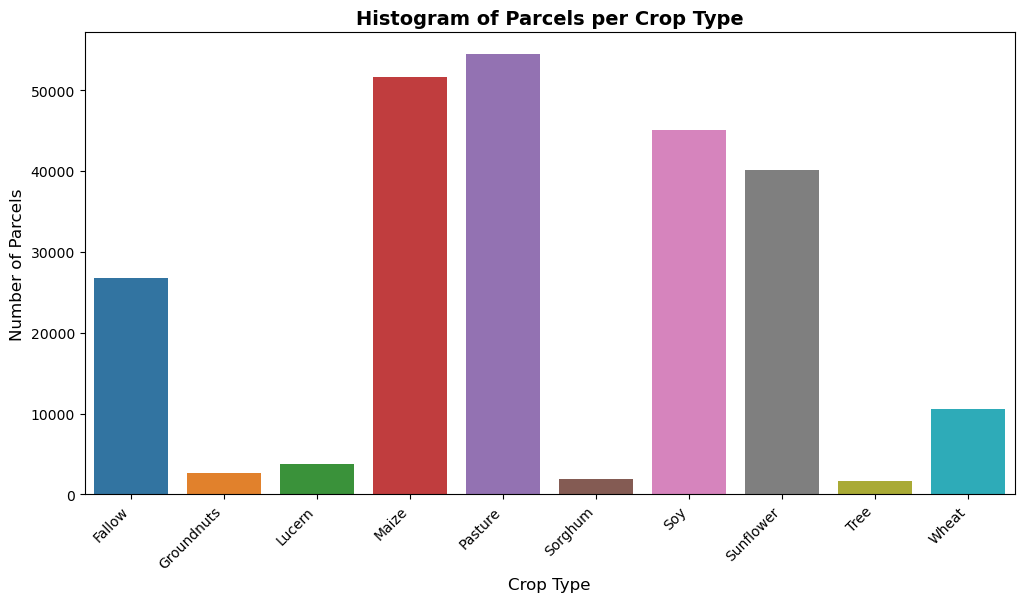

In [16]:
# Ensure Crop_type column exists
if "Crop_type" not in df1.columns:
    raise ValueError("The dataframe df is missing the 'Crop_type' column.")

# Count unique FIELDID values per Crop_type
crop_counts = df1.groupby('Crop_type')['FIELDID'].nunique().reset_index()
crop_counts.columns = ['Crop_type', 'Parcel_Count']

# Define distinct colors for each crop type
colors = plt.cm.get_cmap('tab10', len(crop_counts))  # Use 'tab10' colormap
crop_color_map = {crop: colors(i) for i, crop in enumerate(crop_counts['Crop_type'])}

# Plot the histogram
fig, ax = plt.subplots(figsize=(12, 6))

sns.barplot(
    x='Crop_type', y='Parcel_Count', data=crop_counts,
    palette=[crop_color_map[crop] for crop in crop_counts['Crop_type']]
)

# Improve readability
ax.set_title("Histogram of Parcels per Crop Type", fontsize=14, fontweight='bold')
ax.set_xlabel("Crop Type", fontsize=12)
ax.set_ylabel("Number of Parcels", fontsize=12)
ax.set_xticklabels(crop_counts['Crop_type'], rotation=45, ha='right')  # Rotate x-axis labels

plt.show()

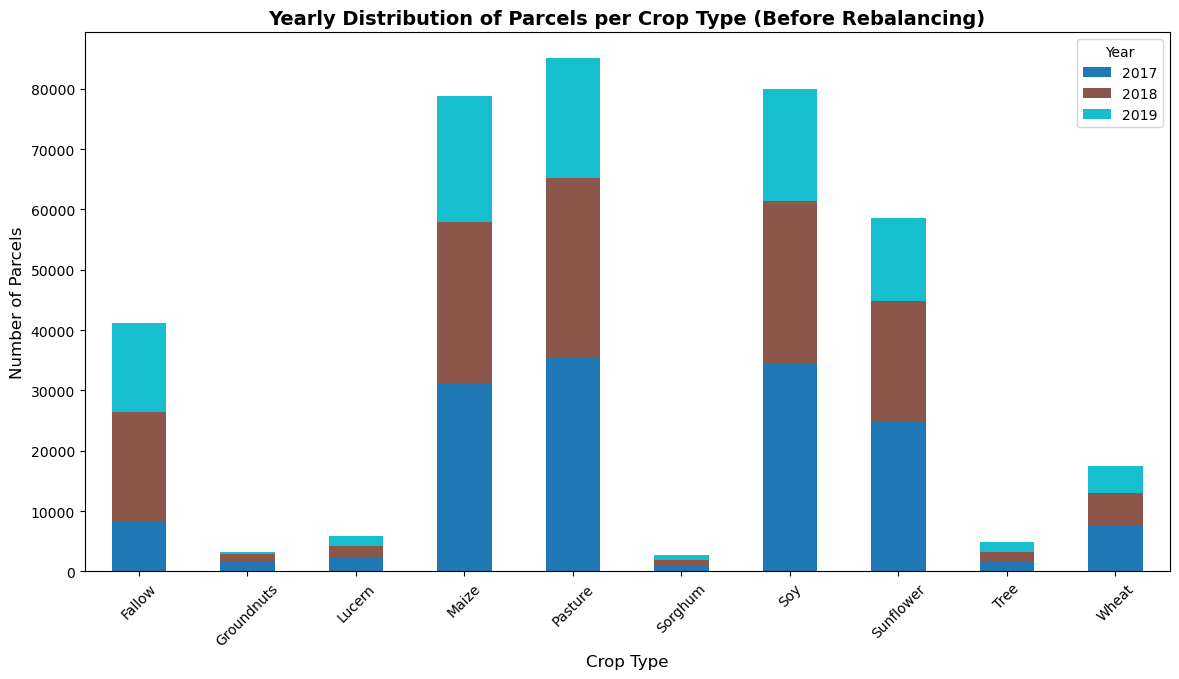

In [17]:
# Ensure required columns exist
required_columns = {"Crop_type", "FIELDID", "Year"}
missing = required_columns - set(df1.columns)
if missing:
    raise ValueError(f"The dataframe df3 is missing the columns: {missing}")

# Compute the number of unique FIELDIDs per crop per year before rebalancing
crop_year_counts_original = df1.groupby(["Crop_type", "Year"])["FIELDID"].nunique().unstack()

# Plot the original distribution
fig, ax = plt.subplots(figsize=(14, 7))

crop_year_counts_original.plot(kind="bar", stacked=True, cmap=cm.get_cmap("tab10"), ax=ax)

ax.set_title("Yearly Distribution of Parcels per Crop Type (Before Rebalancing)", fontsize=14, fontweight="bold")
ax.set_xlabel("Crop Type", fontsize=12)
ax.set_ylabel("Number of Parcels", fontsize=12)
ax.legend(title="Year")

plt.xticks(rotation=45)
plt.show()

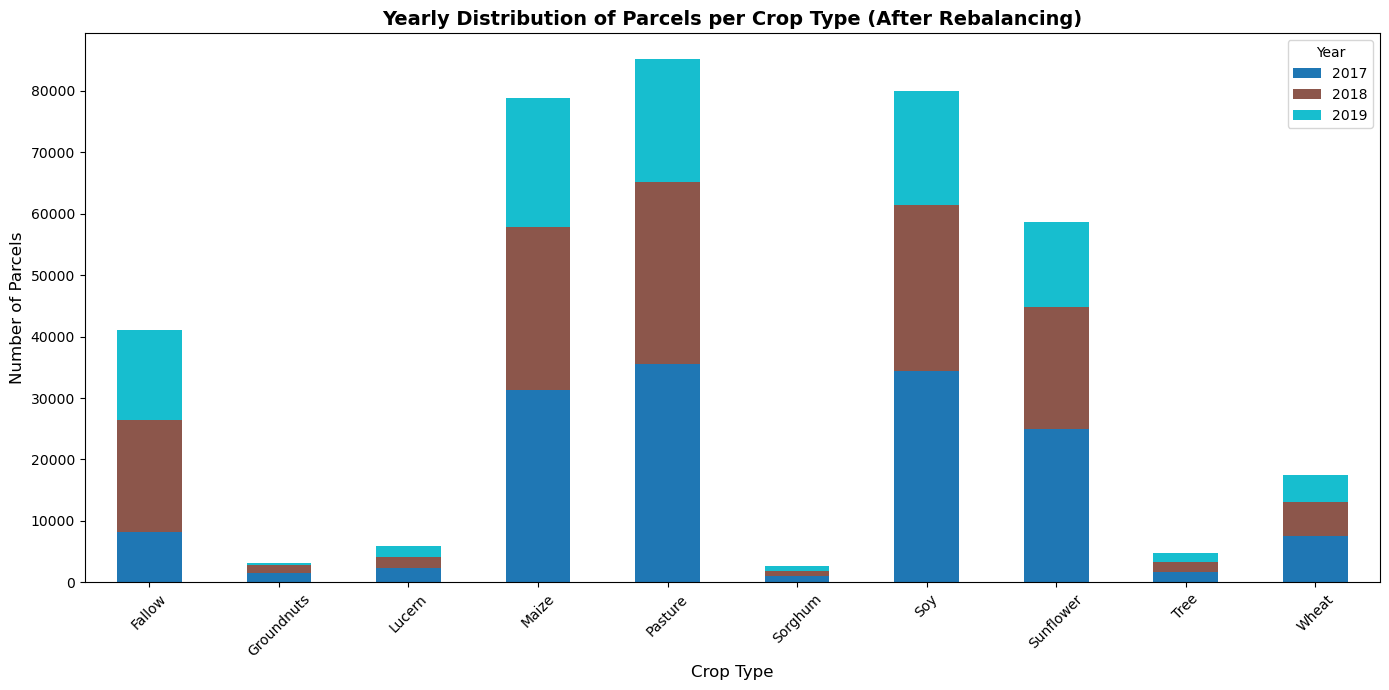

In [ ]:
# Ensure required columns exist
required_columns = {"Crop_type", "FIELDID", "Year"}
missing = required_columns - set(df1.columns)
if missing:
    raise ValueError(f"The dataframe df1 is missing the columns: {missing}")

# Define max parcels per crop *per year*
max_parcels_dict = {
    "Maize": 1000000,
    "Soy": 1000000,
    "Sunflower": 1000000,
    "Wheat": 1000000,
    "Lucern": 1000000,
    "Pasture": 40000,
    "Tree": 1000000,
    "Fallow": 1000000,
    "Groundnuts": 100000,
    "Sorghum": 100000
}

# Start with an empty list to collect filtered data
balanced_parts = []

# Loop through crops and years
for crop, max_per_year in max_parcels_dict.items():
    crop_df = df1[df1["Crop_type"] == crop]

    for year, year_df in crop_df.groupby("Year"):
        unique_fieldids = year_df["FIELDID"].unique()
        if len(unique_fieldids) <= max_per_year:
            selected_ids = unique_fieldids  # keep all
        else:
            selected_ids = np.random.choice(unique_fieldids, size=max_per_year, replace=False)

        # Keep only selected FIELDIDs
        filtered_df = year_df[year_df["FIELDID"].isin(selected_ids)]
        balanced_parts.append(filtered_df)

# Combine all filtered parts
df1_balanced = pd.concat(balanced_parts, ignore_index=True)

# Compute counts after rebalancing
crop_year_counts_balanced = df1_balanced.groupby(["Crop_type", "Year"])["FIELDID"].nunique().unstack()

# Plot the balanced distribution
fig, ax = plt.subplots(figsize=(14, 7))
crop_year_counts_balanced.plot(kind="bar", stacked=True, cmap=cm.get_cmap("tab10"), ax=ax)

ax.set_title("Yearly Distribution of Parcels per Crop Type (After Rebalancing)", fontsize=14, fontweight="bold")
ax.set_xlabel("Crop Type", fontsize=12)
ax.set_ylabel("Number of Parcels", fontsize=12)
ax.legend(title="Year")

plt.xticks(rotation=45)
plt.tight_layout()
# plt.ylim(0, 14500)  # Adjust y-axis limit for better visibility
plt.show()


In [21]:
# Identify vegetation and SAR predictor columns
veg_predictors = [col for col in df1.columns if col.startswith('veg_')]
sar_predictors = [col for col in df1.columns if col.startswith('sar_')]

# Define crop-specific invalid week rules
def is_invalid_sample(crop, week, irrigation):
    invalid_weeks = {
        "Maize": (22, 40), "Soy": (22, 40), "Sunflower": (22, 40),
        "Pasture": (22, 40), "Tree": (22, 40), "Fallow": (22, 40),
        "Groundnuts": (22, 40), "Sorghum": (22, 40), "Wheat": (47, 17)
    }
    if crop == "Lucern":
        return week < 17 or week > 47 if irrigation == 1 else 22 <= week <= 40
    if crop in invalid_weeks:
        out_start, out_end = invalid_weeks[crop]
        if out_start < out_end:
            return out_start <= week <= out_end
        else:
            return week >= out_start or week <= out_end
    return False

# Step 1: Mark valid crop weeks
df1['is_valid_week'] = ~df1.apply(lambda row: is_invalid_sample(
    row['Crop_type'], row['week'], row['Irrigation']), axis=1)

# Step 2: Filter only valid crop weeks
df_valid = df1[df1['is_valid_week']].copy()

# Step 3: For each FIELDID-Year-Crop_type, count valid rows where all veg_ and sar_ predictors are present
group_cols = ['FIELDID', 'Year', 'Crop_type']
valid_counts = (
    df_valid
    .groupby(group_cols, group_keys=False)
    .apply(lambda group: pd.Series({
        'veg_valid': group[veg_predictors].notnull().all(axis=1).sum(),
        'sar_valid': group[sar_predictors].notnull().all(axis=1).sum()
    }))
    .reset_index()
)

# Step 4: Keep groups with ≥ selected_number fully valid veg and sar weeks
valid_triplets = valid_counts[
    (valid_counts['veg_valid'] >= min_valid_weeks) &
    (valid_counts['sar_valid'] >= min_valid_weeks)
][group_cols]

# Step 5: Filter the original df1 to retain only valid (FIELDID, Year, Crop_type) combinations
df2 = df1.merge(valid_triplets, on=group_cols, how='inner').drop(columns=['is_valid_week'])

# Step 6: Optional summary
print(f"Original FIELDID-Year-Crop groups: {df1[group_cols].drop_duplicates().shape[0]}")
print(f"Filtered groups retained: {df2[group_cols].drop_duplicates().shape[0]}")
print(f"Remaining rows in df2: {df2.shape[0]}")


/var/folders/jz/41vp_9w11rj9bnb6_5xhp_gw0000gn/T/ipykernel_16526/4230649486.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_valid


Original FIELDID-Year-Crop groups: 377619
Filtered groups retained: 120751
Remaining rows in df2: 2077810


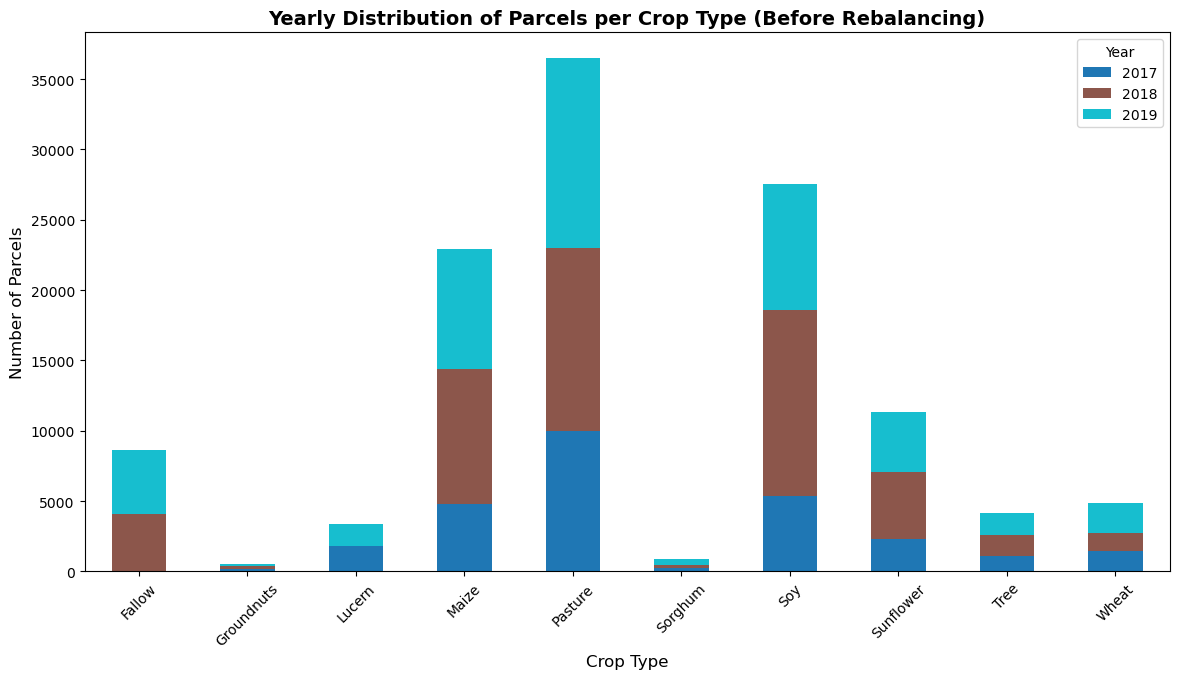

In [22]:
# Ensure required columns exist
required_columns = {"Crop_type", "FIELDID", "Year"}
missing = required_columns - set(df2.columns)
if missing:
    raise ValueError(f"The dataframe df3 is missing the columns: {missing}")

# Compute the number of unique FIELDIDs per crop per year before rebalancing
crop_year_counts_original = df2.groupby(["Crop_type", "Year"])["FIELDID"].nunique().unstack()

# Plot the original distribution
fig, ax = plt.subplots(figsize=(14, 7))

crop_year_counts_original.plot(kind="bar", stacked=True, cmap=cm.get_cmap("tab10"), ax=ax)

ax.set_title("Yearly Distribution of Parcels per Crop Type (Before Rebalancing)", fontsize=14, fontweight="bold")
ax.set_xlabel("Crop Type", fontsize=12)
ax.set_ylabel("Number of Parcels", fontsize=12)
ax.legend(title="Year")

plt.xticks(rotation=45)
plt.show()

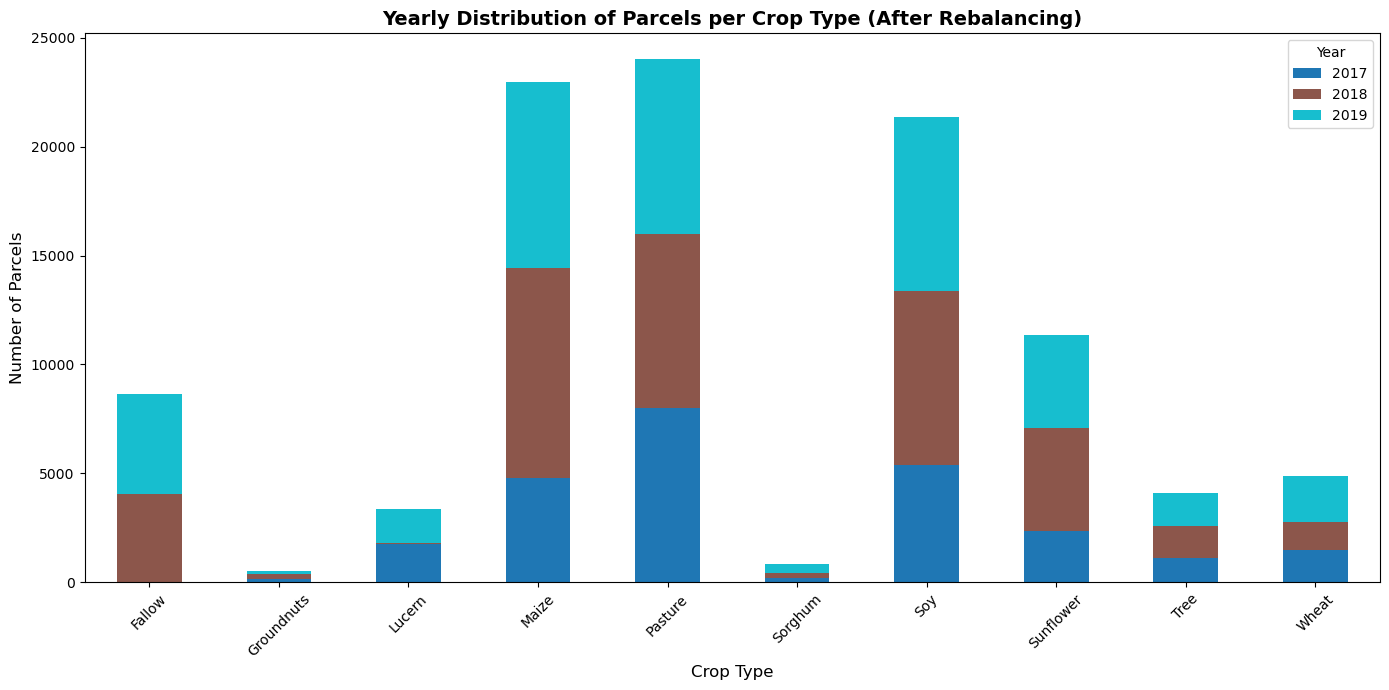

In [ ]:
# Ensure required columns exist
required_columns = {"Crop_type", "FIELDID", "Year"}
missing = required_columns - set(df2.columns)
if missing:
    raise ValueError(f"The dataframe df2 is missing the columns: {missing}")

# 10: Define max parcels per crop *per year*
max_parcels_dict = {
    "Maize": 100000,
    "Soy": 8000,
    "Sunflower": 100000,
    "Wheat": 100000,
    "Lucern": 100000,
    "Pasture": 8000,
    "Tree": 100000,
    "Fallow": 100000,
    "Groundnuts": 100000,
    "Sorghum": 100000
}

# Start with an empty list to collect filtered data
balanced_parts = []

# Loop through crops and years
for crop, max_per_year in max_parcels_dict.items():
    crop_df = df2[df2["Crop_type"] == crop]

    for year, year_df in crop_df.groupby("Year"):
        unique_fieldids = year_df["FIELDID"].unique()
        if len(unique_fieldids) <= max_per_year:
            selected_ids = unique_fieldids  # keep all
        else:
            selected_ids = np.random.choice(unique_fieldids, size=max_per_year, replace=False)

        # Keep only selected FIELDIDs
        filtered_df = year_df[year_df["FIELDID"].isin(selected_ids)]
        balanced_parts.append(filtered_df)

# Combine all filtered parts
df2_balanced = pd.concat(balanced_parts, ignore_index=True)

# Compute counts after rebalancing
crop_year_counts_balanced = df2_balanced.groupby(["Crop_type", "Year"])["FIELDID"].nunique().unstack()

# Plot the balanced distribution
fig, ax = plt.subplots(figsize=(14, 7))
crop_year_counts_balanced.plot(kind="bar", stacked=True, cmap=cm.get_cmap("tab10"), ax=ax)

ax.set_title("Yearly Distribution of Parcels per Crop Type (After Rebalancing)", fontsize=14, fontweight="bold")
ax.set_xlabel("Crop Type", fontsize=12)
ax.set_ylabel("Number of Parcels", fontsize=12)
ax.legend(title="Year")

plt.xticks(rotation=45)
plt.tight_layout()
# plt.ylim(0, 14500)  # Adjust y-axis limit for better visibility
plt.show()


In [30]:
# Save df_limited to a new CSV file
out_path = 'InputModel'
# Save both df1 and df1_balanced to CSV files
if not os.path.exists(out_path):
    os.makedirs(out_path)

In [31]:
# SB{min_valid_weeks}r
output_filename_balanced2 = os.path.join(out_path, f'SB{min_valid_weeks}r_n0.2_process1.csv')
# save df2_balanced to a new CSV file
df2_balanced.to_csv(output_filename_balanced2, index=False)